# Numerical Optimization and Large Scale Linear Algebra 
# Assignment 3b
## Ilias Katsampalos

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, tril, triu, identity
from scipy.sparse.linalg import spsolve_triangular
import time

# 1. Construct the Adjacency Matrix

In [2]:
data = pd.read_csv('stanweb.dat', delimiter='\t', header=None)
data.columns = ['from_node', 'to_node', 'weight']
# -1 in order to adjust the indices to start at 0
data.from_node -= 1
data.to_node -= 1

In [3]:
n = data.from_node.max() +1 
G = csr_matrix((data.weight, (data.to_node, data.from_node)), shape=(n,n))

# 2. Adjust for dangling columns

Chapter 4 describes how the dangling nodes could be stored and combined with the original Adjacency matrix efficiently. This could be achieved with creating a vector $a$ where $a_i = 1$ if the ith node is of degree 0 and $a_i = 1$ otherwise. Taking the outer product of **v**, which is a n dimensional vector where each element is $v_i = \frac{1}{n}$ (where n is the number of nodes) with **a**, we create a sparse rank one matrix. Then we can have the following expression:

$$\bar{G} = G + va^T$$

In [112]:
#find nodes that have incoming connections but no outgoing connections
diff = np.setdiff1d(data.to_node, data.from_node)
a = np.zeros(n)
a[diff] = 1
v = np.ones((n,1)) / n
e = np.ones((n,1))

## 3. Transitioning

Transitioning occurs where a user types a specific web page into the browser rather than keeping on traversing the graph. We define with the probability `t` the event that a user keeps on traversing the graph and `1-t` the probability to transition arbitarily to any other page.

Thus the original adjacency matrix could be expressed as:
$$\bar{\bar{G}} = t\bar{G} + (1-t)ve^T = t(G + va^T) + (1-t)ve^T$$

# 4. The Power Method

The power method involves the solution of the eigenvector problem
$$x^{k+1} = \bar{\bar{G}}x^{k}$$

We can solve the system above iterativeley.
$$
\begin{align*}
    x^{k+1} &= \bar{\bar{G}}x^{k}\\
    &= (t\bar{G} + (1-t)ve^T)x^{k} \\
    &= t\bar{G}x^{k} + (1-t)ve^Tx^{k}
\end{align*}
$$

$e^Tx^{k} = 1$ since $e^T=[1,1,1...1]$ n times and $x^{k}$ must sum to 1 since it is a probability distribution vector.
Thus we have:
$$
\begin{align*}
    x^{k+1} &= \bar{\bar{G}}x^{k}\\
    &= (t\bar{G} + (1-t)ve^T)x^{k} \\
    &= t\bar{G}x^{k} + (1-t)ve^Tx^{k}\\
    &= t\bar{G}x^{k} + (1-t)v\\
    &= t(G+va^T)x^{k} + (1-t)v\\
    &= tGx^{k} + tva^Tx^{k} + (1-t)v\\
    &= tGx^{k} + [ta^Tx^{k} + (1-t)]v\\
\end{align*}
$$

where 
* t: probability to transition to any arbitary node
* G: the initial sparse matrix
* v: [1/n, 1/n, ..., 1/n] n dimensional vector
* a: the vector containing 1s if a node is dangling and 0 otherwise


In [344]:
def power_method(G, a, t, tol=1e-8, max_iter=1000, return_iter_per_rank=False):
    
    start_time = time.time()
    
    n = G.shape[0]
    #initialize the error
    rel_error = np.finfo('double').max
    #initialize the ranking x
    x = np.ones(n) / n

    transition = (1-t) / np.ones(n)
    #initialize v as 1/number of nodes
    v = np.ones(n) / n
    
    iter_counter = 0
    #flag for creating array that will hold the number of iterations 
    #until convergence of each element
    if return_iter_per_rank:
        iter_per_rank = np.zeros(n)
    
    #start the iterative process
    while rel_error > tol and iter_counter <= max_iter:
        #calculate x_next
        x_next = t * G @ x + (t * a.T @ x + (1-t)) * v
        #normalize x_next so that it sums to 1 (probability dist vector)
        x_next /= np.linalg.norm(x_next, ord=1)
        #calculate the relative error ||x_next - x|| / ||x||
        rel_error = np.linalg.norm(x_next - x) / np.linalg.norm(x)
        
        #if flag return_iter_per_rank is true
        if return_iter_per_rank:
            #calculate the diffs per element
            diffs = np.abs(x_next - x) / np.abs(x)
            #update with the number of iteration if the diff is greater than the tolerance
            iter_per_rank[np.where(diffs > tol)] = iter_counter
        
        # x <- x_next
        x = x_next.copy()
        iter_counter += 1
    
    end_time = time.time()
    print(f'Finished in {end_time - start_time:.2f}s. Iterations: {iter_counter-1}, relative error: {rel_error}')
    if return_iter_per_rank:
        return x, iter_per_rank
    else:    
        return x.argsort()[::-1][:n]

# The Linear System Method

We need to solve for:

$$
\begin{align*}
    x &= \bar{\bar{G}}x\\
    &= (t\bar{G} + (1-t)ve^T)x \\
    &= t\bar{G}x + (1-t)ve^Tx\\
    &= t\bar{G}x + (1-t)v\\
\end{align*}
$$

since as described above $e^Tx^{k} = 1$ since $e^T=[1,1,1...1]$ n times and $x^{k}$ must sum to 1 since it is e probability distribution vector.

Continuing:

$$
\begin{align*}
    &x = t\bar{G}x + (1-t)v\\
    &\Rightarrow x - t\bar{G}x = (1-t)v\\
    &\Rightarrow (I - t\bar{G})x = (1-t)v\\
\end{align*}
$$

Subsituting with the original G matrix we obtain:

$$
\begin{align*}
    &\Rightarrow (I - t\bar{G})x = (1-t)v\\
    &\Rightarrow (I - tG - tva^T)x = (1-t)v\\
\end{align*}
$$

Since $va^T$ could be quite dense depending on the number of dangling nodes, we can proceed with the following method.

$$
\begin{align*}
    &\Rightarrow (I - t\bar{G})x = (1-t)v\\
    &\Rightarrow (I - tG)x - tva^Tx = (1-t)v\\
    &\Rightarrow (I - tG)x - tva^Tx = (1-t)v\\
    &\Rightarrow (I - tG)x = tva^Tx + (1-t)v\\
\end{align*}
$$

Using the Gauss Seidel method we can proceed further with:

$$
\begin{align*}
    &\Rightarrow (I - tG)x = tva^Tx + (1-t)v\\
    &\Rightarrow DL(I - tG)x = U(I - tG) + tva^Tx + (1-t)v\\
\end{align*}
$$

where $DL(I - tG)$ is the diagonal and lower triangular matrix of $I-tG$ and $U(I - tG)$ is the relevant upper tringular matrix.

In [363]:
def gauss_seidel(G, a, t, tol=1e-8, max_iter=1000, return_iter_per_rank=False):
    start_time = time.time()
    
    n = G.shape[0]
    #initialize v as 1/number of nodes
    v = np.ones(n) / n
    #calculate b only once
    b = (1-t) * v
    
    #gauss seidel matrices
    A = identity(n) - t*G
    #DL lower triangular of A including diagonal
    DL = tril(A)
    #U upper triangular
    U = -triu(A, 1)
    
    iter_counter = 0
    
    #if the flag return_iter_per_rank is true initialize array
    #which will hold the number of iterations until
    #convergence of each element
    if return_iter_per_rank:
        iter_per_rank = np.zeros(n)
    
    #initialize the relative error and x
    rel_error = np.finfo('double').max
    x = np.ones(n) / n
    
    #start of gauss seidel iteration
    while rel_error > tol and iter_counter <= max_iter:
        #calculate b_hat
        b_hat = U @ x + t*v*(a.T @ x) + b
        #spsolve_triangular method for solving efficiently triangular systems
        x_next = spsolve_triangular(DL, b_hat)
        #normalize x_next to sum to 1, since probability distribution vector
        x_next /= np.linalg.norm(x_next, ord=1)
        #calculate the relative error
        rel_error = np.linalg.norm(x_next - x, ord=2) / np.linalg.norm(x, ord=2)
        
        #if the flag return_iter_per_rank is true
        if return_iter_per_rank:
            #calculate the difference per element
            diffs = np.abs(x_next - x) / np.abs(x)
            #update with the number of iterations if not converged
            iter_per_rank[np.where(diffs > tol)] = iter_counter
                   
        x = x_next.copy()
        iter_counter += 1
    
    end_time = time.time()
    print(f'Finished in {end_time - start_time:.2f}s. Iterations: {iter_counter-1}, relative error: {rel_error}')
    if return_iter_per_rank:
        return x, iter_per_rank
    else:    
        return x.argsort()[::-1][:n]

# a) Execution Statistics for t = 0.85

Power Method

In [323]:
power_method_ranks = power_method(G, a, 0.85)
power_method_ranks[:10]

Finished in 3.17s. Iterations: 94, relative error: 9.425222278561278e-09


array([ 89072, 226410, 241453, 262859, 134831, 234703, 136820,  68888,
       105606,  69357], dtype=int64)

In [362]:
gauss_seidel_ranks = gauss_seidel(G, a, 0.85)

Finished in 182.64s. Iterations: 48, relative error: 7.397145442617967e-09


We can create a scatterplot with the rankings of gauss seidel and the power method.
If there are no big deviations in the ranking, then the scatterplot should resemble the straight line $x=y$.

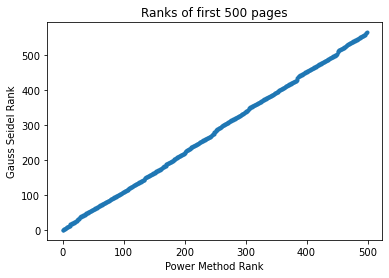

In [247]:
from matplotlib import pyplot as plt
first_500 = np.where(power_method_ranks == gauss_seidel_ranks)[0][:500]
plt.scatter(list(range(500)), first_500, marker = '.')
plt.title('Ranks of first 500 pages')
plt.xlabel('Power Method Rank')
plt.ylabel('Gauss Seidel Rank')
plt.show()

Observations:
* We can see that there are no big deviations between the ranking produces by the Power method and the Gauss Seidel method, at least for the first 500 webpages.
* The power method finished in 3 seconds with 94 iterations. 
* The Gauss Seidel method made less iterations but the execution time was very large, above 100s.

# b) Execution Statistics for t = 0.99

In [272]:
power_method_ranks_99 = power_method(G, a, 0.99, max_iter=1e6)

Finished in 55.20s. Iterations: 1511, relative error: 9.942196858011447e-09


In [263]:
gauss_seidel_ranks_99 = gauss_seidel(G, a, 0.99, max_iter=1e6)

Finished in 1430.06s. Iterations: 678, relative error: 9.89050790801261e-09


#### Power method comparison t=0.85 vs t=0.99

In [279]:
#how many web pages had the same rank in the first 50
same_rank = sum(power_method_ranks_99[:50] == power_method_ranks[:50])
#how many web pages exist in the first 50, irrespective of ranking
in_first_50 = sum(np.isin(power_method_ranks_99[:50], power_method_ranks[:50]))
print(f'Common nodes in first 50: {in_first_50} from which {same_rank} had the same rank')

Common nodes in first 50: 25 from which 1 had the same rank


#### Gauss Seidel method comparison t=0.85 vs t=0.99

In [280]:
#how many web pages had the same rank in the first 50
same_rank = sum(gauss_seidel_ranks_99[:50] == gauss_seidel_ranks[:50])
#how many web pages exist in the first 50, irrespective of ranking
in_first_50 = sum(np.isin(gauss_seidel_ranks_99[:50], gauss_seidel_ranks[:50]))
print(f'Common nodes in first 50: {in_first_50} from which {same_rank} had the same rank')

Common nodes in first 50: 25 from which 1 had the same rank


In both cases we observed that when using 0.01 transition probability, only 25 nodes were included in the set of pages produced from which the transition probability was 0.15. Additionally, only 1 page had the same ranking between the two trials (probability of transition=0.01 and probability of transition = 0.15)

# c) Convergence

#### Power Method

In [368]:
#call power_method with return_iter_per_rank=True
pm_probs, pm_iterations = power_method(G, a, 0.85, return_iter_per_rank=True, tol=1e-13)

Finished in 6.72s. Iterations: 165, relative error: 8.797584505010734e-14


In [376]:
#create a dataframe with the results
pm_res = pd.DataFrame({'probs':pm_probs, 'iterations':pm_iterations})
#sort by the probability of visit descending
pm_res.sort_values(by='probs', ascending=False, inplace=True)
#create 100 quantiles based on the indexes (since sorted)
pm_res['order_bucket'] = pd.qcut(pm_res.index,100,labels=range(1,101))
#for each bucket find the average number of iterations for convergence
pm_agg = pm_res.groupby('order_bucket').iterations.mean().reset_index()

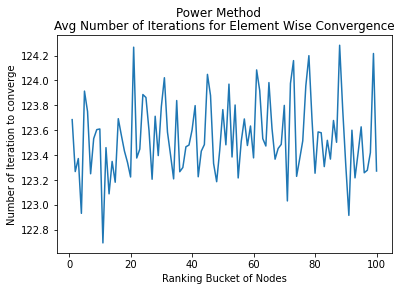

In [377]:
plt.plot(pm_agg.order_bucket, pm_agg.iterations)
plt.xlabel('Ranking Bucket of Nodes')
plt.ylabel('Number of Iteration to converge')
plt.suptitle('Power Method')
plt.title('Avg Number of Iterations for Element Wise Convergence')
plt.show()

Linear System Method

In [371]:
gs_probs, gs_iterations = gauss_seidel(G, a, 0.85, return_iter_per_rank=True)

C:\Users\ikats\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:552: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  warn('CSR matrix format is required. Converting to CSR matrix.',


Finished in 103.48s. Iterations: 48, relative error: 7.397145442617967e-09


In [372]:
#create a dataframe with the results
gs_res = pd.DataFrame({'probs':gs_probs, 'iterations':gs_iterations})
#sort by the probability of visit descending
gs_res.sort_values(by='probs', ascending=False, inplace=True)
#create 100 quantiles based on the indexes (since sorted)
gs_res['order_bucket'] = pd.qcut(gs_res.index,100,labels=range(1,101))
#for each bucket find the average number of iterations for convergence
agg = gs_res.groupby('order_bucket').iterations.mean().reset_index()

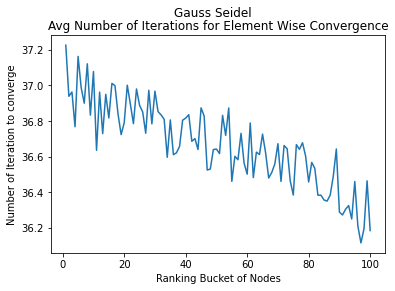

In [375]:
plt.plot(agg.order_bucket, agg.iterations)
plt.xlabel('Ranking Bucket of Nodes')
plt.ylabel('Number of Iteration to converge')
plt.suptitle('Gauss Seidel')
plt.title('Avg Number of Iterations for Element Wise Convergence')
plt.show()

We can observe that in the `power method`, the avg number of iterations per ranking bucket does not show any particular pattern. As a result, there is no clear distinction as to whether important nodes converge faster or slower than non important ones. On the contrary, in the gauss-seidel method, we can observe that more important nodes have on average higher numbers of iterations in order to converge element-wise to their limits. 

# Theoretical questions

The following questions are answered based on the methodology provide in 
https://snap.stanford.edu/class/cs246-2013/slides/09-pagerank.pdf

### a) Adding a page `x` with no in/out connections

Having the adjacency metric formatted such that the rows indicate inward links where the columns indicate outward links we can define the rank of an element j as:

$$r_j = \sum_{i\rightarrow j} \beta \frac{r_i}{d_i} + \frac{1-b}{n}$$

where $d_i$ is the outward degree of node $A_{ij}$ and $\beta$ the probability to continue browsing using the links instead of transitioning randomly to a web page.

Adding one more web page `x` we have the following:

$$r_x = \sum_{i\rightarrow j} \beta \frac{r_i}{d_i} + \frac{1-b}{n+1}$$

But since the page `x` does not have inwards or outwards links, there is only one elemnt in the respective diagonal element of the adjacency matrix. Thus we obtain:

$$r_x = \beta r_x + \frac{1-b}{n+1} \Rightarrow  r_x (1-\beta) = \frac{1-b}{n+1} \Rightarrow r_x = \frac{1}{n+1}$$

For the rest of the pages the ranking changes slightly, since the transitioning matrix changes from $\frac{1}{n}$ to $\frac{1}{n+1}$ which has minimum impact since n is very large.

### b) Adding a page `y` which links to `x`

We have:

$$r_x = \sum_{i\rightarrow j} \beta \frac{r_i}{d_i} + \frac{1-b}{n+2} = \beta r_x + \beta \frac{r_y}{2} + \frac{1-\beta}{n+2}$$ (since y is pointing to itself as well as `x` it has a degree if 2)

Similarly to `a)` $r_y = \frac{1}{n+2}$ so $r_x$ becomes:
$$r_x = \beta r_x + \frac{\beta}{2(n+2)} + \frac{1-\beta}{n+2}$$

Solving for $r_x$ we obtain:

$$r_x = \frac{2-\beta}{2(n+2)(1-\beta)}$$

which is higher than $r_x$ without the presence of `y` pointing to it.

In [27]:
beta = 0.85
n = 100

r_x_a = 1/(n+1)
r_x_y = (2-beta) / (2*(n+2)*(1-beta))
print(f'r_x without the presence of y = {r_x_a} in a graph {n}x{n} and beta={beta}')
print(f'r_x with the presence of y = {r_x_y} in a graph {n}x{n} and beta={beta}')

r_x without the presence of y = 0.009900990099009901 in a graph 100x100 and beta=0.85
r_x with the presence of y = 0.03758169934640522 in a graph 100x100 and beta=0.85


### c) Adding another page `z`
In order to maximize the rank of the page `x` we have to adjust both `y` and `z` to point to `x`.
Additionally `y` and `z` shoulf point to each other as well as `x` should point to them.

### d) adding outgoing links from x

Based on the ranking formula, what matters is the inwards links from older pages to `x`. The number of outgoing pages from `x` will not have an effect on the page ranking of `x` itself. On the contrary, it will increase slightly the ranking of the older pages since they have one more incoming link. 

If we add links from `z` or `y` to older pages, the ranking of `x` will decrease. This is because all outwards links of a node must sum to `1`. So if before `y` was pointing only to `x`, `x` received an incoming link of weight `1/2` (since `y` is pointing to itself as well). If `y` has more outwards links, the weight if the connection to `x` will drop, eventually decreasing the ranking of `y`.

### e) Increasing the page rank of `x`

Based on the logic of the pagerank algorithm, in order to increase the rank of the page `x`, it must receive incoming connections from nodes which:

* receive many connections themselves, so that their ranking is high
* do not have many outwards connections, so that their degree is small. In other words, the lesser the outward links of a webpage, the higher the importance of the connection.